<a href="https://colab.research.google.com/github/StarCloudes/DataAnalyst/blob/master/multi_class_classification_of_handwritten_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # 使用神经网络对手写数字进行分类

 ![img](https://www.tensorflow.org/versions/r0.11/images/MNIST.png)

 **学习目标：**
  * 训练线性模型和神经网络，以对传统 [MNIST](http://yann.lecun.com/exdb/mnist/) 数据集中的手写数字进行分类
  * 比较线性分类模型和神经网络分类模型的效果
  * 可视化神经网络隐藏层的权重

 我们的目标是将每个输入图片与正确的数字相对应。我们会创建一个包含几个隐藏层的神经网络，并在顶部放置一个归一化指数层，以选出最合适的类别。

 ## 设置

首先，我们下载数据集、导入 TensorFlow 和其他实用工具，并将数据加载到 *Pandas* `DataFrame`。请注意，此数据是原始 MNIST 训练数据的样本；我们随机选择了 20000 行。

In [1]:
from __future__ import print_function

import glob
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

mnist_dataframe = pd.read_csv(
  "https://download.mlcc.google.cn/mledu-datasets/mnist_train_small.csv",
  sep=",",
  header=None)

# Use just the first 10,000 records for training/validation.
mnist_dataframe = mnist_dataframe.head(10000)

mnist_dataframe = mnist_dataframe.reindex(np.random.permutation(mnist_dataframe.index))
mnist_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
8919,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4159,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8321,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3085,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 第一列中包含类别标签。其余列中包含特征值，每个像素对应一个特征值，有 `28×28=784` 个像素值，其中大部分像素值都为零；您也许需要花一分钟时间来确认它们不*全部*为零。

 ![img](https://www.tensorflow.org/versions/r0.11/images/MNIST-Matrix.png)

 这些样本都是分辨率相对较低、对比度相对较高的手写数字图片。`0-9` 这十个数字中的每个可能出现的数字均由唯一的类别标签表示。因此，这是一个具有 10 个类别的多类别分类问题。

现在，我们解析一下标签和特征，并查看几个样本。注意 `loc` 的使用，借助 `loc`，我们能够基于原来的位置抽出各列，因为此数据集中没有标题行。

In [0]:
def parse_labels_and_features(dataset):
  """Extracts labels and features.
  
  This is a good place to scale or transform the features if needed.
  
  Args:
    dataset: A Pandas `Dataframe`, containing the label on the first column and
      monochrome pixel values on the remaining columns, in row major order.
  Returns:
    A `tuple` `(labels, features)`:
      labels: A Pandas `Series`.
      features: A Pandas `DataFrame`.
  """
  labels = dataset[0]

  # DataFrame.loc index ranges are inclusive at both ends.
  features = dataset.loc[:,1:784]
  # Scale the data to [0, 1] by dividing out the max value, 255.
  features = features / 255

  return labels, features

In [3]:
training_targets, training_examples = parse_labels_and_features(mnist_dataframe[:7500])
training_examples.describe()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,...,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
validation_targets, validation_examples = parse_labels_and_features(mnist_dataframe[7500:10000])
validation_examples.describe()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,...,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.1,0.0,0.2,1.0,0.2,0.0,0.0,0.0,0.0


 显示一个随机样本及其对应的标签。

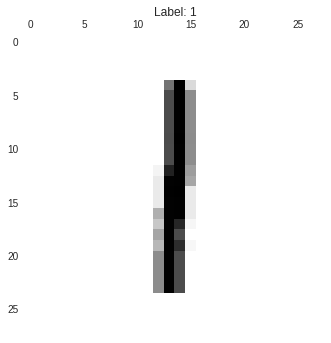

In [5]:
rand_example = np.random.choice(training_examples.index)
_, ax = plt.subplots()
ax.matshow(training_examples.loc[rand_example].values.reshape(28, 28))
ax.set_title("Label: %i" % training_targets.loc[rand_example])
ax.grid(False)

 ## 任务 1：为 MNIST 构建线性模型

首先，我们创建一个基准模型，作为比较对象。`LinearClassifier` 可提供一组 *k* 类一对多分类器，每个类别（共 *k* 个）对应一个分类器。

您会发现，除了报告准确率和绘制对数损失函数随时间变化情况的曲线图之外，我们还展示了一个[**混淆矩阵**](https://en.wikipedia.org/wiki/Confusion_matrix)。混淆矩阵会显示错误分类为其他类别的类别。哪些数字相互之间容易混淆？

另请注意，我们会使用 `log_loss` 函数跟踪模型的错误。不应将此函数与用于训练的 `LinearClassifier` 内部损失函数相混淆。

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  
  # There are 784 pixels in each image. 
  return set([tf.feature_column.numeric_column('pixels', shape=784)])

 在本次练习中，我们会对训练和预测使用单独的输入函数，并将这些函数分别嵌套在 `create_training_input_fn()` 和 `create_predict_input_fn()` 中，这样一来，我们就可以调用这些函数，以返回相应的 `_input_fn`，并将其传递到 `.train()` 和 `.predict()` 调用。

In [0]:
def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True):
  """A custom input_fn for sending MNIST data to the estimator for training.

  Args:
    features: The training features.
    labels: The training labels.
    batch_size: Batch size to use during training.

  Returns:
    A function that returns batches of training features and labels during
    training.
  """
  def _input_fn(num_epochs=None, shuffle=True):
    # Input pipelines are reset with each call to .train(). To ensure model
    # gets a good sampling of data, even when number of steps is small, we 
    # shuffle all the data before creating the Dataset object
    idx = np.random.permutation(features.index)
    raw_features = {"pixels":features.reindex(idx)}
    raw_targets = np.array(labels[idx])
   
    ds = Dataset.from_tensor_slices((raw_features,raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

In [0]:
def create_predict_input_fn(features, labels, batch_size):
  """A custom input_fn for sending mnist data to the estimator for predictions.

  Args:
    features: The features to base predictions on.
    labels: The labels of the prediction examples.

  Returns:
    A function that returns features and labels for predictions.
  """
  def _input_fn():
    raw_features = {"pixels": features.values}
    raw_targets = np.array(labels)
    
    ds = Dataset.from_tensor_slices((raw_features, raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size)
    
        
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

In [0]:
def train_linear_classification_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model for the MNIST digits dataset.
  
  In addition to training, this function also prints training progress information,
  a plot of the training and validation loss over time, and a confusion
  matrix.
  
  Args:
    learning_rate: A `float`, the learning rate to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing the training features.
    training_targets: A `DataFrame` containing the training labels.
    validation_examples: A `DataFrame` containing the validation features.
    validation_targets: A `DataFrame` containing the validation labels.
      
  Returns:
    The trained `LinearClassifier` object.
  """

  periods = 10

  steps_per_period = steps / periods  
  # Create the input functions.
  predict_training_input_fn = create_predict_input_fn(
    training_examples, training_targets, batch_size)
  predict_validation_input_fn = create_predict_input_fn(
    validation_examples, validation_targets, batch_size)
  training_input_fn = create_training_input_fn(
    training_examples, training_targets, batch_size)
  
  # Create a LinearClassifier object.
  my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(),
      n_classes=10,
      optimizer=my_optimizer,
      config=tf.estimator.RunConfig(keep_checkpoint_max=1)
  )

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss error (on validation data):")
  training_errors = []
  validation_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
  
    # Take a break and compute probabilities.
    training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
    training_probabilities = np.array([item['probabilities'] for item in training_predictions])
    training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
    training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)
        
    validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
    validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
    validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
    validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)    
    
    # Compute training and validation errors.
    training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
    validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, validation_log_loss))
    # Add the loss metrics from this period to our list.
    training_errors.append(training_log_loss)
    validation_errors.append(validation_log_loss)
  print("Model training finished.")
  # Remove event files to save disk space.
  _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
  
  # Calculate final predictions (not probabilities, as above).
  final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
  final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
  
  
  accuracy = metrics.accuracy_score(validation_targets, final_predictions)
  print("Final accuracy (on validation data): %0.2f" % accuracy)

  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.plot(training_errors, label="training")
  plt.plot(validation_errors, label="validation")
  plt.legend()
  plt.show()
  
  # Output a plot of the confusion matrix.
  cm = metrics.confusion_matrix(validation_targets, final_predictions)
  # Normalize the confusion matrix by row (i.e by the number of samples
  # in each class).
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  ax = sns.heatmap(cm_normalized, cmap="bone_r")
  ax.set_aspect(1)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()

  return classifier

 **花费 5 分钟的时间了解一下使用这种形式的线性模型时，准确率方面表现如何。在本次练习中，为自己设定限制，仅使用批量大小、学习速率和步数这三个超参数进行试验。**

如果您从上述任何试验中得到的准确率约为 0.9，即可停止试验。

 ### 解决方案


 以下是一组使准确率应该约为 0.9 的参数。

Training model...
LogLoss error (on validation data):
  period 00 : 4.68
  period 01 : 4.27
  period 02 : 3.98
  period 03 : 3.83
  period 04 : 3.72
  period 05 : 3.50
  period 06 : 3.51
  period 07 : 3.44
  period 08 : 3.36
  period 09 : 3.45
Model training finished.
Final accuracy (on validation data): 0.90


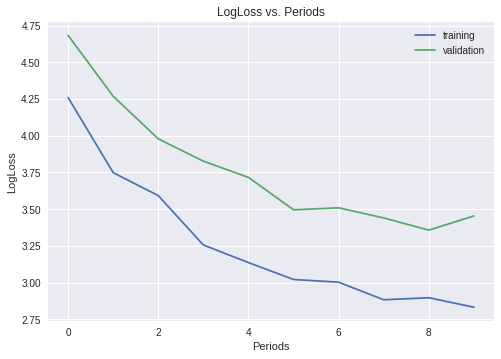

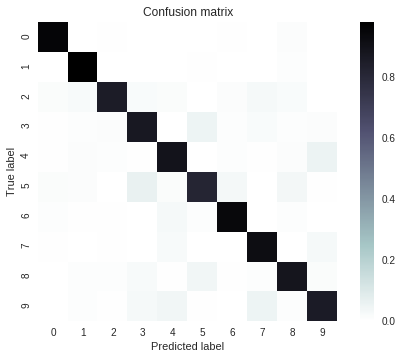

In [10]:
_ = train_linear_classification_model(
    learning_rate=0.03,
    steps=1000,
    batch_size=30,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 任务 2：使用神经网络替换线性分类器

**使用 [`DNNClassifier`](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier) 替换上面的 LinearClassifier，并查找可实现 0.95 或更高准确率的参数组合。**

您可能希望尝试 Dropout 等其他正则化方法。这些额外的正则化方法已记录在 `DNNClassifier` 类的注释中。

 获得出色的模型后，通过评估我们将在下面加载的测试数据进行仔细检查，确认您没有过拟合验证集。

 ### 解决方案


 除了神经网络专用配置（例如隐藏单元的超参数）之外，以下代码与原始的 `LinearClassifer` 训练代码几乎完全相同。

In [0]:
def train_nn_classification_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network classification model for the MNIST digits dataset.
  
  In addition to training, this function also prints training progress information,
  a plot of the training and validation loss over time, as well as a confusion
  matrix.
  
  Args:
    learning_rate: A `float`, the learning rate to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing the training features.
    training_targets: A `DataFrame` containing the training labels.
    validation_examples: A `DataFrame` containing the validation features.
    validation_targets: A `DataFrame` containing the validation labels.
      
  Returns:
    The trained `DNNClassifier` object.
  """

  periods = 10
  # Caution: input pipelines are reset with each call to train. 
  # If the number of steps is small, your model may never see most of the data.  
  # So with multiple `.train` calls like this you may want to control the length 
  # of training with num_epochs passed to the input_fn. Or, you can do a really-big shuffle, 
  # or since it's in-memory data, shuffle all the data in the `input_fn`.
  steps_per_period = steps / periods  
  # Create the input functions.
  predict_training_input_fn = create_predict_input_fn(
    training_examples, training_targets, batch_size)
  predict_validation_input_fn = create_predict_input_fn(
    validation_examples, validation_targets, batch_size)
  training_input_fn = create_training_input_fn(
    training_examples, training_targets, batch_size)
  
  # Create the input functions.
  predict_training_input_fn = create_predict_input_fn(
    training_examples, training_targets, batch_size)
  predict_validation_input_fn = create_predict_input_fn(
    validation_examples, validation_targets, batch_size)
  training_input_fn = create_training_input_fn(
    training_examples, training_targets, batch_size)
  
  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column('pixels', shape=784)]

  # Create a DNNClassifier object.
  my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  classifier = tf.estimator.DNNClassifier(
      feature_columns=feature_columns,
      n_classes=10,
      hidden_units=hidden_units,
      optimizer=my_optimizer,
      config=tf.contrib.learn.RunConfig(keep_checkpoint_max=1)
  )

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss error (on validation data):")
  training_errors = []
  validation_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
  
    # Take a break and compute probabilities.
    training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
    training_probabilities = np.array([item['probabilities'] for item in training_predictions])
    training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
    training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)
        
    validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
    validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
    validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
    validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)    
    
    # Compute training and validation errors.
    training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
    validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, validation_log_loss))
    # Add the loss metrics from this period to our list.
    training_errors.append(training_log_loss)
    validation_errors.append(validation_log_loss)
  print("Model training finished.")
  # Remove event files to save disk space.
  _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
  
  # Calculate final predictions (not probabilities, as above).
  final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
  final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
  
  
  accuracy = metrics.accuracy_score(validation_targets, final_predictions)
  print("Final accuracy (on validation data): %0.2f" % accuracy)

  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.plot(training_errors, label="training")
  plt.plot(validation_errors, label="validation")
  plt.legend()
  plt.show()
  
  # Output a plot of the confusion matrix.
  cm = metrics.confusion_matrix(validation_targets, final_predictions)
  # Normalize the confusion matrix by row (i.e by the number of samples
  # in each class).
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  ax = sns.heatmap(cm_normalized, cmap="bone_r")
  ax.set_aspect(1)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()

  return classifier

Training model...
LogLoss error (on validation data):
  period 00 : 6.48
  period 01 : 4.23
  period 02 : 2.51
  period 03 : 2.57
  period 04 : 2.25
  period 05 : 2.09
  period 06 : 2.17
  period 07 : 2.24
  period 08 : 2.03
  period 09 : 2.02
Model training finished.
Final accuracy (on validation data): 0.94


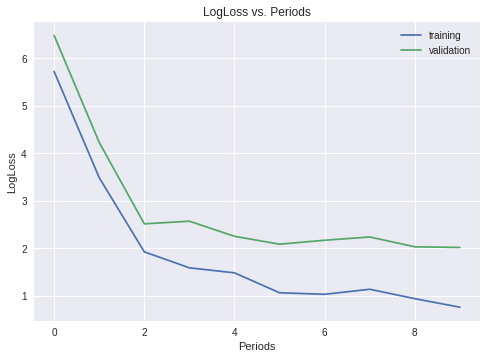

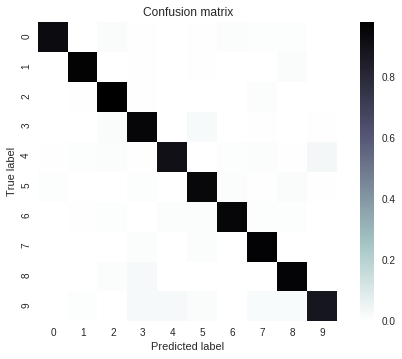

In [14]:
classifier = train_nn_classification_model(
    learning_rate=0.05,
    steps=1000,
    batch_size=30,
    hidden_units=[100, 100],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 接下来，我们来验证测试集的准确率。

In [15]:
mnist_test_dataframe = pd.read_csv(
  "https://download.mlcc.google.cn/mledu-datasets/mnist_test.csv",
  sep=",",
  header=None)

test_targets, test_examples = parse_labels_and_features(mnist_test_dataframe)
test_examples.describe()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
predict_test_input_fn = create_predict_input_fn(
    test_examples, test_targets, batch_size=100)

test_predictions = classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['class_ids'][0] for item in test_predictions])
  
accuracy = metrics.accuracy_score(test_targets, test_predictions)
print("Accuracy on test data: %0.2f" % accuracy)

Accuracy on test data: 0.95


 ## 任务 3：可视化第一个隐藏层的权重。

我们来花几分钟时间看看模型的 `weights_` 属性，以深入探索我们的神经网络，并了解它学到了哪些规律。

模型的输入层有 `784` 个权重，对应于 `28×28` 像素输入图片。第一个隐藏层将有 `784×N` 个权重，其中 `N` 指的是该层中的节点数。我们可以将这些权重重新变回 `28×28` 像素的图片，具体方法是将 `N` 个 `1×784` 权重数组*变形*为 `N` 个 `28×28` 大小数组。

运行以下单元格，绘制权重曲线图。请注意，此单元格要求名为 "classifier" 的 `DNNClassifier` 已经过训练。

['dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adagrad', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adagrad', 'dnn/hiddenlayer_1/bias', 'dnn/hiddenlayer_1/bias/t_0/Adagrad', 'dnn/hiddenlayer_1/kernel', 'dnn/hiddenlayer_1/kernel/t_0/Adagrad', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adagrad', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adagrad', 'global_step']
weights0 shape: (784, 100)


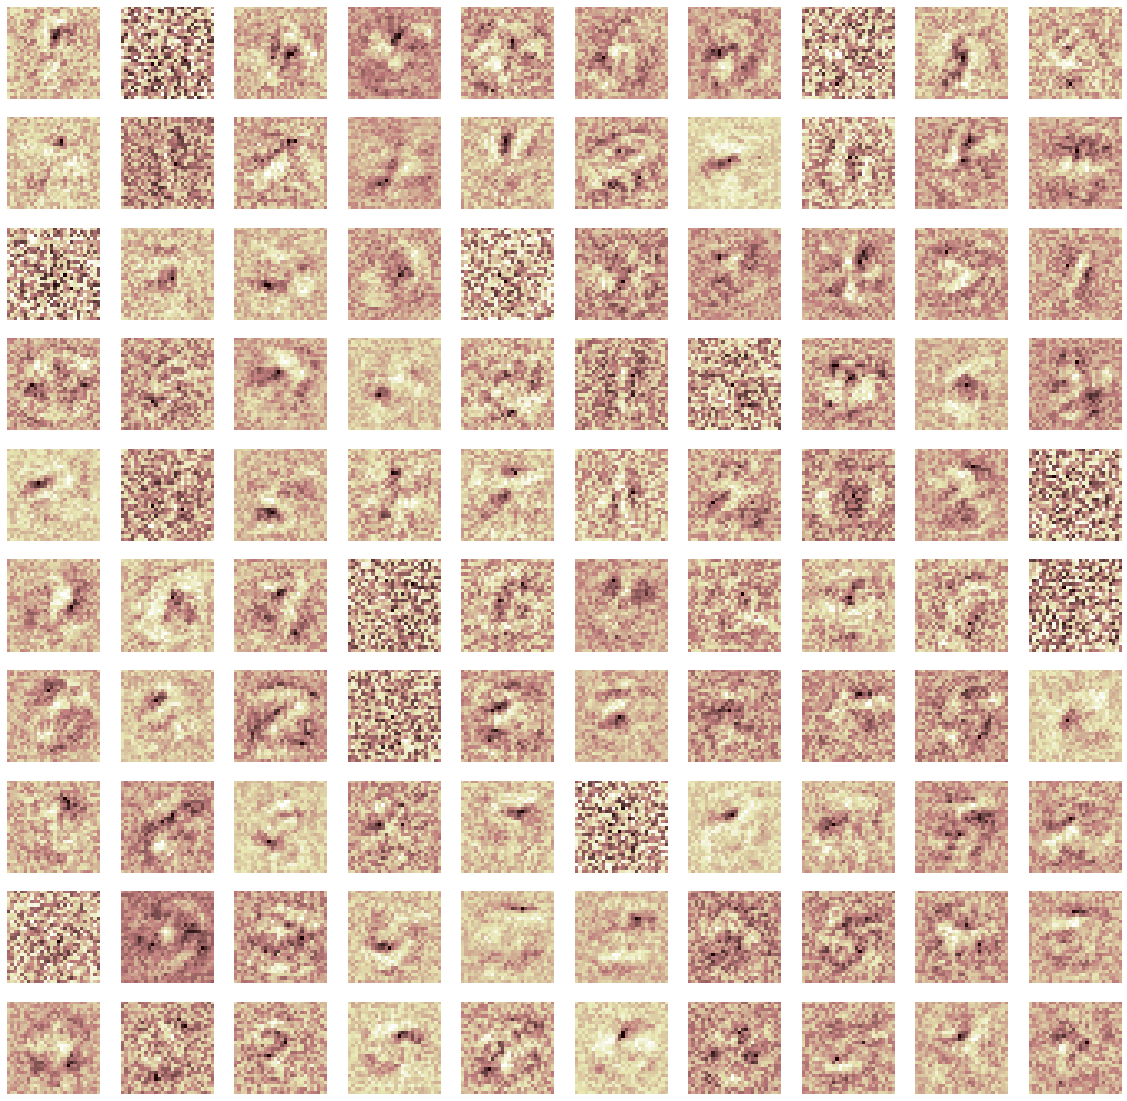

In [17]:
print(classifier.get_variable_names())

weights0 = classifier.get_variable_value("dnn/hiddenlayer_0/kernel")

print("weights0 shape:", weights0.shape)

num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(20, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    # Weights in coef is reshaped from 1x784 to 28x28.
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.pink)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

 神经网络的第一个隐藏层应该会对一些级别特别低的特征进行建模，因此可视化权重可能只显示一些模糊的区域，也可能只显示数字的某几个部分。此外，您可能还会看到一些基本上是噪点（这些噪点要么不收敛，要么被更高的层忽略）的神经元。

在迭代不同的次数后停止训练并查看效果，可能会发现有趣的结果。

**分别用 10、100 和 1000 步训练分类器。然后重新运行此可视化。**

您看到不同级别的收敛之间有哪些直观上的差异？